# Libraries and data importation

In [ ]:
import requests
import pandas
import random
import torch
from torchvision import datasets, transforms,utils
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time
from tqdm import trange, tqdm

folder_path='/home/INF473/artgan/Images/'

classes = 'https://raw.githubusercontent.com/cs-chan/ArtGAN/master/WikiArt%20Dataset/Style/style_class.txt'
train_data='https://github.com/cs-chan/ArtGAN/raw/master/WikiArt%20Dataset/Style/style_train.csv'
test_data='https://github.com/cs-chan/ArtGAN/raw/master/WikiArt%20Dataset/Style/style_val.csv'
images='http://web.fsktm.um.edu.my/~cschan/source/ICIP2017/wikiart.zip'

r = requests.get(classes, allow_redirects=True)
open(folder_path+'classes.txt', 'wb').write(r.content)

r = requests.get(train_data, allow_redirects=True)
open(folder_path+'train_data.csv', 'wb').write(r.content)

r = requests.get(test_data, allow_redirects=True)
open(folder_path+'test_data.csv', 'wb').write(r.content)

"""
r = requests.get(images, allow_redirects=True)
images=open(folder_path+'images.zip', 'wb')
"""

batch_size=128*2
d=100
            
img_dim=64   #resize the images

noise_dim=100
n_classes=27

transform = transforms.Compose([
     transforms.Resize(size=(img_dim,img_dim)),
     transforms.ToTensor()
])
transform2 = transforms.Compose([
     transforms.ToTensor()
])





def import_classes():
    classes=[]
    
    with open(folder_path+'style_class.txt') as c:
        text=c.readlines()
        for line in text:
            words=line.split(" ")
            style=words[1].split("\n")[0]
            style_words=style.split("_")
            style=''
            for word in style_words:
                if style=='':
                    style+=word
                else:
                    style+=' '+word
            classes.append(style)
    return classes



classes=import_classes()
print(classes)

['Abstract Expressionism', 'Action painting', 'Analytical Cubism', 'Art Nouveau', 'Baroque', 'Color Field Painting', 'Contemporary Realism', 'Cubism', 'Early Renaissance', 'Expressionism', 'Fauvism', 'High Renaissance', 'Impressionism', 'Mannerism Late Renaissance', 'Minimalism', 'Naive Art Primitivism', 'New Realism', 'Northern Renaissance', 'Pointillism', 'Pop Art', 'Post Impressionism', 'Realism', 'Rococo', 'Romanticism', 'Symbolism', 'Synthetic Cubism', 'Ukiyo e']


In [ ]:
def init_train_data(batch_size):
    train_data=[]
    with open(folder_path+'style_train.csv', 'r', encoding='utf8') as f:
        reader=pandas.read_csv(f,encoding='utf-8',delimiter=',',quotechar='"')
        for row in tqdm(reader.values):
            with Image.open(folder_path+'wikiart_resized_64/'+row[0]) as img:
                img = transform2(img)
                row=[img,row[1]]
                train_data.append(row)
                
        train_loader=torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    return train_loader
    
def init_test_data(batch_size):
    test_data=[]
    with open(folder_path+'style_val.csv', 'r', encoding='utf8') as f:
        reader=pandas.read_csv(f,encoding='utf-8',delimiter=',',quotechar='"')
        for row in tqdm(reader.values):
            with Image.open(folder_path+'wikiart_resized_64/'+row[0]) as img:
                img = transform2(img) 
                row=[img,row[1]]
                test_data.append(row)
            
        test_loader=torch.utils.data.DataLoader(test_data, batch_size=batch_size)
    return test_loader

In [ ]:
train_loader = init_train_data(batch_size)

100%|██████████| 56832/56832 [00:22<00:00, 2486.20it/s]


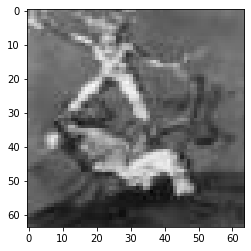

In [ ]:
batch=next(train_loader.__iter__())
plt.imshow(batch[0][48].permute(1,2,0))

In [ ]:
test_loader = init_test_data(batch_size)

100%|██████████| 24320/24320 [00:09<00:00, 2506.24it/s]


# Disciminator

In [ ]:

class D(torch.nn.Module): 
    def __init__(self,n_classes,img_dim):
        super(D,self).__init__()
        self.Conv5=torch.nn.Sequential(
            torch.nn.Conv2d(512,1024,4,stride=2,padding=1),
            torch.nn.BatchNorm2d(1024),
            torch.nn.LeakyReLU(0.2)
            )
        self.fc6=torch.nn.Sequential(
            torch.nn.Linear(1024*(img_dim//16)**2,n_classes+1),
            torch.nn.Sigmoid()
            )
        self.encoder=torch.nn.Sequential(
            torch.nn.Conv2d(3,128,4,stride=2,padding=1),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(128,128,3,stride=1,padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(128,256,4,stride=2,padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(256,512,4,stride=2,padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.LeakyReLU(0.2)
            )
        
    def forward(self, X):
        Z=self.encoder(X)
        X=self.Conv5(Z)
        X=self.fc6(X.view(X.size(0),-1))
        return X
    
    
Dtest=D(n_classes,img_dim)


y=Dtest(batch[0])
print(y.shape)
print(y)

torch.Size([256, 28])
tensor([[0.4790, 0.4472, 0.3679,  ..., 0.4026, 0.4607, 0.6050],
        [0.5389, 0.4067, 0.3812,  ..., 0.4281, 0.5308, 0.5250],
        [0.5012, 0.4351, 0.4825,  ..., 0.5002, 0.4419, 0.6129],
        ...,
        [0.5703, 0.5563, 0.4740,  ..., 0.2813, 0.3842, 0.7117],
        [0.4537, 0.4746, 0.5182,  ..., 0.4416, 0.4777, 0.5481],
        [0.4605, 0.5173, 0.4781,  ..., 0.3705, 0.4509, 0.5845]],
       grad_fn=<SigmoidBackward>)


# Generator

In [ ]:
class G(torch.nn.Module):
    def __init__(self,n_classes,img_dim,noise_dim):
        super(G,self).__init__()
        self.deconv1=torch.nn.Sequential(
            torch.nn.ConvTranspose2d(n_classes+noise_dim,1024,img_dim//16),
            torch.nn.BatchNorm2d(1024),
            torch.nn.ReLU()
            )
        self.deconv2=torch.nn.Sequential(
            torch.nn.ConvTranspose2d(1024,512,4, stride=2, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU()
            )
        self.decoder=torch.nn.Sequential(
            torch.nn.ConvTranspose2d(512,256,4,stride=2,padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(256,128,4,stride=2,padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128,128,3,padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128,3,4,stride=2,padding=1),
            torch.nn.Sigmoid()
            )
        
    def forward(self,X):
        X=self.deconv1(X)
        X=self.deconv2(X)
        X=self.decoder(X)
        return X

Gtest=G(n_classes,img_dim,noise_dim)

# Noise and label vector generator

torch.Size([256, 3, 64, 64])
AxesImage(54,36;334.8x217.44)


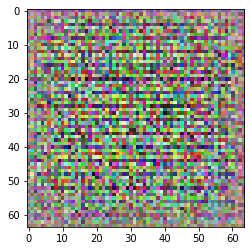

In [ ]:
class NnL_Loader():
    def __init__(self,d,batch_size,n_classes):
        self.d=d
        self.batch_size=batch_size
        self.n_classes=n_classes
        
    def NnL(self):
        Z=torch.normal(0.,1.,(self.batch_size,self.d,1,1))
        Y=torch.zeros((self.batch_size,n_classes,1,1))
        k=torch.randint(0,n_classes,(self.batch_size,))
        for i in range(self.batch_size):
            Y[i,k[i],0,0]=1
        return Z,Y


NnL_loader_test=NnL_Loader(d,batch_size,n_classes)
Z_test,Y_test=NnL_loader_test.NnL()
NnL_test=NnL=torch.cat((Z_test,Y_test),dim=1)
X=Gtest(NnL_test)
print(X.shape)
print(plt.imshow(X[0].permute(1,2,0).detach()))

# ArtGAN

AxesImage(54,36;334.8x217.44)


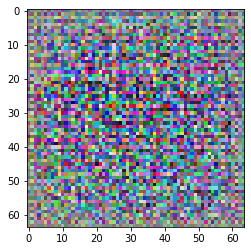

In [ ]:
class ArtGAN(torch.nn.Module):
    def __init__(self,n_classes,img_dim,noise_dim):
        super(ArtGAN,self).__init__()
        
        self.D=D(n_classes,img_dim)
        self.G=G(n_classes,img_dim,noise_dim)
        
        
        """
        On lie les poids des reseaux dec et enc
        """
        
        enc_conv2d_idx=[0,2,5,8]
        dec_deconv2d_idx=[9,6,3,0]
        for i in range(4):
            deconv=self.G.decoder[dec_deconv2d_idx[i]]
            conv=self.D.encoder[enc_conv2d_idx[i]]
            deconv.weight.data=conv.weight.data.transpose(2,3)
        


    def forward(self,X):
        Z=self.D.encoder(X)
        X=self.G.decoder(Z)
        return X

    


artGAN_test=ArtGAN(n_classes,img_dim,noise_dim)
X_copy=0
X_copy=artGAN_test(X)
print(plt.imshow(X_copy[0].permute(1,2,0).detach()))

# Show weights

The filter shape is torch.Size([128, 3, 4, 4])


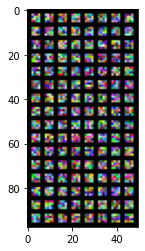

The filter shape is torch.Size([128, 3, 4, 4])


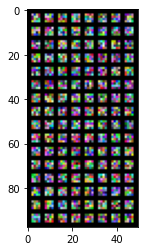

In [ ]:
def imshow_filters(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_weights(layer):
    
    filter = layer.weight.cpu().data
    #Normalizing the values to [0,1]
    f_min, f_max = filter.min(), filter.max()
    filter = (filter - f_min) / (f_max - f_min)
    print("The filter shape is {}".format(filter.shape))
    imshow_filters(utils.make_grid(filter))

def show_weight_enc(D):
    layer=D.encoder[0]
    show_weights(layer)

def show_weight_dec(G):
    layer=G.decoder[-2]
    show_weights(layer)
    
show_weight_enc(artGAN_test.D)

show_weight_dec(artGAN_test.G)

# Loss_function

In [ ]:
class Loss_D():
    def __init__(self,batch_size,n_classes):
        self.batch_size=batch_size
        self.n_classes=n_classes
        self.loss=torch.nn.BCELoss(reduction='mean')
        #A=torch.zeros((batch_size,n_classes))
        #B=torch.ones((batch_size,1))
        #self.fake_vector=torch.cat((A,B),dim=1)
        
        
    def forward(self,Y,lbl,Yhat):
        A=torch.zeros((batch_size,n_classes))
        B=torch.ones((batch_size,1))
        fake_vector=torch.cat((A,B),dim=1)
        

        Y_lbl=torch.zeros((self.batch_size,1+self.n_classes))

        
        for i in range(self.batch_size):
            Y_lbl[i,lbl[i]]=1

        if Y.is_cuda:
            Y_lbl=Y_lbl.type(torch.cuda.FloatTensor)
            fake_vector=fake_vector.type(torch.cuda.FloatTensor)

        loss_D_1=self.loss(Y,Y_lbl)
        loss_D_2=self.loss(Yhat,fake_vector)
        loss_1=loss_D_1+loss_D_2
        
        return loss_1
        
class Loss_adv_L2():
    def __init__(self,batch_size, n_classes):
        self.n_classes=n_classes
        self.loss_adv=torch.nn.BCELoss(reduction='mean')
        self.loss_L2=torch.nn.MSELoss()

        
    def forward(self,Yhat,Yhat_khat,Xr,Xhat_Z):
        Yhat_khat=Yhat_khat.view(-1,self.n_classes)
        #real_add_vector=torch.ones((batch_size,1))
        #for i in range(batch_size):
         #   Y[i,0]=Yhat[i,-1]
        #Yhat_khat=torch.cat((Yhat_khat,real_add_vector),dim=1)

        Yhat = Yhat[:,:self.n_classes]

        #Yhat_khat=torch.cat((Yhat_khat,real_add_vector),dim=1)
        loss_adv=self.loss_adv(Yhat,Yhat_khat)
        loss_L2=self.loss_L2(Xr,Xhat_Z)
        loss_adv_L2=loss_adv+loss_L2
        
        return loss_adv_L2


# Training algorithm

In [ ]:
def train(net, optimizer, train_loader, test_loader, NnL_loader,
          loss_D, loss_adv_L2,A,B,lr=0.001, n_epoch = 5,
          train_acc_period = 100, test_acc_period = 5, cuda=False):
    if cuda:
        net.cuda()
    net.train()
    optimizer_D=optimizer(net.D.parameters(),lr,eps=1e-08)
    optimizer_G=optimizer(net.G.parameters(),lr,eps=1e-08)
    #loss_train = []
    #loss_test = []
    #total = 0
    for epoch in range(n_epoch):
        if epoch==80:
            optimizer.lr/=10
        #running_loss = 0.0
        #running_acc = 0.0
        for i, batch in enumerate(train_loader):
            Zhat,Yhat_khat=NnL_loader.NnL()
            NnL=torch.cat((Zhat,Yhat_khat),dim=1)
            Xr, lbl = batch
            if cuda:
                Xr = Xr.type(torch.cuda.FloatTensor)
                lbl = lbl.type(torch.cuda.LongTensor)
                Yhat_khat = Yhat_khat.type(torch.cuda.FloatTensor)
                NnL = NnL.type(torch.cuda.FloatTensor)
            

            optimizer_D.zero_grad()      
            Y = net.D(Xr)   #Y=D(Xr)
            Xhat=net.G(NnL)   #X_chapeau=G(Z_chapeau,Y_chapeau_k_chapeau)
            Yhat=net.D(Xhat)    #Y_chapeau=D(X_chapeau)
            #L_D <-- Y,k,Y_chapeau,Y_chapeau_k_chapeau
            Loss_D=loss_D.forward(Y,lbl,Yhat)
            Loss_D.backward(retain_graph=True)    #Calcul du gradient de L_D
           
            optimizer_G.zero_grad()  
            Xhat_Z=net(Xr)    #X_chapeau_Z=(Dec(Enc(Xr)))
            #L_adv <-- Y,k   et  L_L2 <-- Y_chapeau,Y_chapeau_k_chapeau
            Loss_adv_L2=loss_adv_L2.forward(Yhat,Yhat_khat,Xr,Xhat_Z)  
            Loss_adv_L2.backward()    #Calcul du gradient de L_adv+L_L2      
            
            optimizer_D.step()    #Mise à jour des poids       
            optimizer_G.step()

        
            print(Loss_D)
            print(Loss_adv_L2)            

            """
            total += labels.size(0)
  
            # print statistics
            running_loss = 0.33*loss.item()/labels.size(0) + 0.66*running_loss
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()/labels.size(0)
            running_acc = 0.3*correct + 0.66*running_acc
            if i % train_acc_period == train_acc_period-1:
              print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss))
              print('[%d, %5d] acc: %.3f' %(epoch + 1, i + 1, running_acc))
              running_loss = 0.0
              total = 0
            """ 
        """
        if epoch % test_acc_period == test_acc_period-1:
            cur_acc, cur_loss = accuracy(net, test_loader, cuda=cuda)
            print('[%d] loss: %.3f' %(epoch + 1, cur_loss))
            print('[%d] acc: %.3f' %(epoch + 1, cur_acc))
        """
        print("ok!!!! "+str(1+epoch))
        torch.save(net,str(1+epoch)+' artGAN_2.3.pt')
        A.append(Loss_D.item())
        B.append(Loss_adv_L2.item())
    print('Finished Training')


In [ ]:
artGAN=ArtGAN(n_classes,img_dim,noise_dim)

if torch.cuda.device_count() > 1:
    torch.nn.DataParallel(artGAN, device_ids=list(range(torch.cuda.device_count())))

NnL_loader=NnL_Loader(d,batch_size,n_classes)
loss_D=Loss_D(batch_size,n_classes)
loss_adv_L2=Loss_adv_L2(batch_size,n_classes)

In [ ]:
#artGAN = torch.load('1 artGAN_2.1.pt')

The filter shape is torch.Size([128, 3, 4, 4])


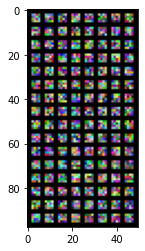

The filter shape is torch.Size([128, 3, 4, 4])


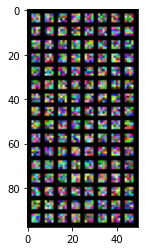

In [ ]:
show_weight_enc(artGAN.D)

show_weight_dec(artGAN.G)

In [ ]:
A = []
B = []

In [ ]:
train(artGAN,torch.optim.Adam,train_loader,test_loader,NnL_loader,
      loss_D, loss_adv_L2,A,B,lr=0.001,n_epoch=100,cuda=True)

tensor(1.4028, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8092, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3527, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4575, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5320, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3858, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2762, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3445, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2787, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2882, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4372, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3627, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2624, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2384, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2442, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2358, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2267, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2301, device='cuda:0', grad_fn=<AddBack

In [ ]:
artGAN.eval()

In [ ]:
Z,Y=NnL_loader_test.NnL()
print(torch.argmax(Y[0]))
Vecteur_bruit=torch.cat((Z,Y),dim=1)
Vecteur_bruit = Vecteur_bruit.type(torch.cuda.FloatTensor)
Exoevre = artGAN.G(Vecteur_bruit)
print(Exoevre.size())
plt.imshow(Exoevre[0].cpu().detach().permute(1,2,0))

In [ ]:
X=artGAN(Exoevre)
X = X.cpu()
X = X.detach()

plt.imshow(X[0].permute(1,2,0))


In [ ]:
X = X.cpu()
X = X.detach()
plt.imshow(X[0].permute(1,2,0))

In [ ]:
A
MyFile=open('LosD_1.1.txt','w')
for element in A:
     MyFile.write(str(element))
     MyFile.write('\n')
MyFile.close()

In [ ]:
B
MyFile=open('Los_ADv_L2.2.txt','w')
for element in B:
     MyFile.write(str(element))
     MyFile.write('\n')
MyFile.close()

# Save the model

In [ ]:
torch.save(artGAN,str(0)+'model1.pt')

In [ ]:
model_save = torch.load('model1.pt')

In [ ]:
X_copy=model_save(X)
print(plt.imshow(X_copy[0].permute(1,2,0).detach()))